# Generate (message, image) recommendations for each user

In [1]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style='ticks', palette='Set2', font='monospace', font_scale=1.)


def get_embedding(text):
    """Compute embedding for a given text string."""
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)


def center_embeddings(df):
    """Offset embeddings by it's center."""
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)


def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x."""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def visualize_embeddings():
    """Plot PCA projection of embeddings."""
    # compute embedding pca
    embs = np.array(messages.embedding.tolist() + images.embedding.tolist() + users.embedding.tolist())
    emb_pca = PCA(n_components=2).fit_transform(embs)
    messages_pca, images_pca, users_pca = np.split(emb_pca, [len(messages),-len(users)])

    # plot pca for messages, images, users
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(messages_pca[:,0], messages_pca[:,1], s=100)
    ax.scatter(images_pca[:,0], images_pca[:,1], s=100)
    ax.scatter(users_pca[:,0], users_pca[:,1], s=100)

    # add legend
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[0], label='messages')
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[1], label='images')
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[2], label='users')
    ax.legend()
    
    # configure axes
    (x0, y0), (x1, y1) = 1.25*emb_pca.min(axis=0), 1.25*emb_pca.max(axis=0)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)    
    plt.tight_layout()
    plt.show()


def get_embedding_user(user, wl=.2, wd=.2):
    """Compute user embeddings accounting for likes and dislikes."""
    demo = f'{user.Age} year old {user.Race.lower()} {user.Gender.lower()}'
    emb = get_embedding(demo)

    # positively adjust embedding for likes
    for like in user.Likes.split(';'):
        print(like, end=' ')
        emb += wl * get_embedding(like)
    
    # negatively adjust embedding for dislikes
    for dislike in user.Dislikes.split(';'):
        print(dislike, end=' ')
        emb -= wd * get_embedding(dislike)
    
    return emb


def get_prefs(pref='norm', temp=.1, k=5):
    """Compute (user,message,image) proximity and return top k recommendations."""
    num_messages = len(messages)
    num_images = len(images)

    # compute preferences
    user_prefs = []
    for u, user_emb in enumerate(users.embedding):
        prefs = np.zeros((num_messages, num_images))
        for i, message_emb in enumerate(messages.embedding):
            for j, image_emb in enumerate(images.embedding):

                if pref == 'norm':
                    prefs[i][j] = -np.linalg.norm(user_emb - message_emb)\
                                - np.linalg.norm(user_emb - image_emb)\
                                - np.linalg.norm(message_emb - image_emb)
                elif pref == 'cos':
                    prefs[i][j] = cossim(user_emb, message_emb)\
                                + cossim(user_emb, image_emb)\
                                + cossim(message_emb, image_emb)
                elif pref == 'dot':
                    prefs[i][j] = np.dot(user_emb, message_emb)\
                                + np.dot(user_emb, image_emb)\
                                + np.dot(message_emb, image_emb)
                elif pref == 'ans':
                    prefs[i][j] = anssim(user_emb, message_emb)\
                                + anssim(user_emb, image_emb)\
                                + anssim(message_emb, image_emb)

        # normalize preferences
        probs = softmax(prefs.reshape(1,-1), temp=temp).reshape(num_messages, num_images)
        user_prefs.append(probs)

        # show k best recommendations for each person
        user = users.iloc[u]
        print(f"Demographics: {user.Age} year old {user.Race.lower()} {user.Gender.lower()}")
        print(f"Likes: {', '.join(user.Likes.split(';'))}")
        print(f"Dislikes: {', '.join(user.Dislikes.split(';'))}\n")
        for ii, jj in zip(*np.unravel_index(np.argsort(probs, axis=None)[-1:-k-1:-1], probs.shape)):
            print(f'#{jj}/#{ii} ({100*probs[ii][jj]:2.0f}%): '\
                  + f'{images.loc[jj].Caption}\n{messages.loc[ii].Message}\n')
        print('================================================\n')

    return user_prefs


def cossim(emb1, emb2):
    """Compute cosine similarity between two embeddings."""
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))


def anssim(emb1, emb2):
    """Compute AnS similarity between two embeddings."""
    cos = (1 - cossim(emb1, emb2)) / 2
    euc = np.linalg.norm(emb1 - emb2) / np.sqrt(len(emb1))
    dist = (cos/2 + cos*euc + euc/2) / 2
    return -dist


## Load and process content data

In [2]:
messages = pd.read_csv('./data/messages.csv')
messages['embedding'] = messages['Message'].apply(get_embedding)
messages

,Unnamed: 0,Message,embedding
0,0,Get up and groove! Dancing is your ticket to f...,"[-0.018363969400525093, -0.02265520766377449, ..."
1,1,"Ditch the screen, hit the trail! Discover natu...","[0.004874080419540405, -0.014436902478337288, ..."
2,2,Give your eyes a break and let your body flow ...,"[-0.010543269105255604, -0.012533052824437618,..."
3,3,Hey! Why not leave the screen behind and hop o...,"[0.014402525499463081, -0.014138374477624893, ..."
4,4,Step away from the screen and let's stroll! Wa...,"[0.008825580589473248, -0.015763133764266968, ..."
5,5,Dive into the pool and feel the freedom! Swap ...,"[0.00595455477014184, -0.0062295845709741116, ..."
6,6,Why not give your thumbs a break and start pum...,"[-0.01912401057779789, -0.028402743861079216, ..."
7,7,Hey! Ready to get moving? Put down the screen ...,"[-0.00423669908195734, -0.017857780680060387, ..."
8,8,Step away from the screen and let's roll! Expe...,"[0.005596579518169165, -0.017040908336639404, ..."
9,9,Step away from the screen and tee off into a w...,"[0.0009409974445588887, -0.021286888048052788,..."


In [3]:
images = pd.read_csv('./data/images.csv')
images['embedding'] = images['Caption'].apply(get_embedding)
images

,Unnamed: 0,Caption,embedding
0,0,"male, young, indian, playing guitar, smiling, ...","[-0.011073106899857521, -0.00667153112590313, ..."
1,1,"woman, adult, white, sitting at a desk, writing","[-0.010561104863882065, 0.00019753891683649272..."
2,2,"woman, adult, white, preparing food, preparing...","[0.012420755811035633, -0.0264976117759943, -0..."
3,3,"senior, white, male, holding a book, walking","[0.008945196866989136, -0.024809764698147774, ..."
4,4,"female, adult, white, reading a book with a be...","[-0.01518737617880106, -0.011518959887325764, ..."
5,5,"senior, white, male, sewing, working on a sewi...","[-0.027806641533970833, -0.03539504483342171, ..."
6,6,"female, young, adult, and smiling while leanin...","[-0.0005487035377882421, 0.007427122909575701,..."
7,7,"young, white, male, listening to music, headph...","[-0.006932427175343037, -0.01554698683321476, ..."
8,8,"male, adult, white, working on wood, making fu...","[0.007630762178450823, -0.01660093292593956, -..."
9,9,"female, young, asian, taking a photo with a ca...","[-0.021007735282182693, 0.0020092143677175045,..."


In [4]:
users = pd.read_csv('./data/users.csv', dtype='str')
users['embedding'] = users.apply(get_embedding_user, axis=1)
users

physical creative music active sports games cerebral domestic domestic indoors music sports physical outdoors games cerebral sports music active creative physical cerebral domestic indoors creative domestic indoors music physical sports cerebral active cerebral indoors creative music sports physical domestic active active creative music domestic sports indoors cerebral physical indoors sports active cerebral physical music creative domestic music indoors active cerebral sports physical creative domestic physical music sports indoors creative cerebral domestic active domestic creative cerebral music sports indoors physical active sports indoors creative cerebral physical music domestic active indoors music cerebral active sports physical creative domestic creative domestic music sports indoors cerebral physical active active cerebral indoors sports physical music creative domestic music indoors cerebral active sports physical creative domestic physical creative domestic music sports ind

,Unnamed: 0,Gender,Age,Race,Likes,Dislikes,embedding
0,0,Male,45,White,physical;creative;music;active,sports;games;cerebral;domestic,"[-0.006988288112916053, -0.03585481401532888, ..."
1,1,Female,33,Hispanic,domestic;indoors;music;sports,physical;outdoors;games;cerebral,"[-0.009232636843807996, 0.005110693909227848, ..."
2,2,Male,27,Asian,sports;music;active;creative,physical;cerebral;domestic;indoors,"[-0.0028353460773359977, -0.017715276125818493..."
3,3,Female,52,African American,creative;domestic;indoors;music,physical;sports;cerebral;active,"[-0.006471731350757182, -0.015513226483017206,..."
4,4,Male,55,White,cerebral;indoors;creative;music,sports;physical;domestic;active,"[-0.004995064961258322, -0.016258258279412987,..."
5,5,Female,29,Asian,active;creative;music;domestic,sports;indoors;cerebral;physical,"[-0.007014051330043004, -0.016196728125214575,..."
6,6,Male,65,Hispanic,indoors;sports;active;cerebral,physical;music;creative;domestic,"[-0.016017915098927915, 0.021324724797159435, ..."
7,7,Female,38,African American,music;indoors;active;cerebral,sports;physical;creative;domestic,"[-0.018693095562048255, -0.014232272002846002,..."
8,8,Male,70,Asian,physical;music;sports;indoors,creative;cerebral;domestic;active,"[0.012781468106550165, -0.013776679337024688, ..."
9,9,Female,21,White,domestic;creative;cerebral;music,sports;indoors;physical;active,"[-0.020562063110992315, -0.0022607780061662183..."


## Visualize content embeddings

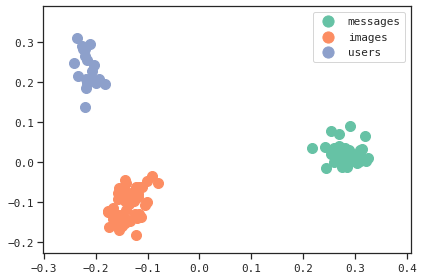

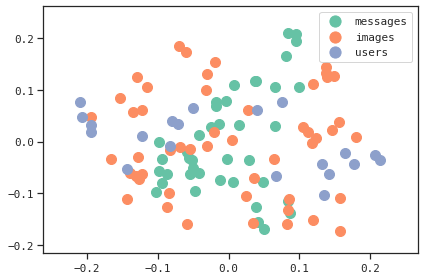

In [5]:
visualize_embeddings()
for df in [messages, images, users]:
    center_embeddings(df)
visualize_embeddings()

## Compute recommendations

In [6]:
prefs = get_prefs(pref='dot', temp=.01)

Demographics: 45 year old white male
Likes: physical, creative, music, active
Dislikes: sports, games, cerebral, domestic

#8/#35 (64%): male, adult, white, working on wood, making furniture
Get off your screen and embrace the joy of woodworking! Discover the satisfaction of creating something with your own hands while unleashing your imagination and reducing stress. Start your woodworking adventure today!

#48/#6 ( 5%): female, young, adult, and white, and they are lifting a barbell
Why not give your thumbs a break and start pumping some iron? Weightlifting will boost your strength, tone your muscles, and leave you feeling unstoppable!

#44/#17 ( 4%): senior, male, white, playing with a rubik's cube
Feeling screen overload? Time to conquer the colorful challenge of a Rubik's cube! Unleash your problem-solving skills, improve focus, and enjoy a satisfying victory! Let's cube it!

#33/#1 ( 3%): young, white, male, backpack, hiking, mountain, forest, view
Ditch the screen, hit the trail!